<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Target Trial Emulation: Translating R Code to Python
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    This notebook demonstrates how to translate R code for Target Trial Emulation (TTE) into Python. We will use the <code style="color: #800020; font-family: 'Courier New', monospace;">statsmodels</code> library to fit generalized linear models (GLMs) and perform inverse probability weighting (IPW) to estimate treatment effects.
    </p>
</div>



<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Setup
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    In this section, we begin by setting up the environment and importing necessary libraries such as <strong>numpy</strong> for numerical operations, <strong>pandas</strong> for data handling, <strong>matplotlib</strong> for plotting, and <strong>statsmodels</strong> for fitting generalized linear models (GLMs). We also use <strong>os</strong> and <strong>pathlib</strong> for file system operations. After importing the libraries, we load the dataset from a CSV file named <code>data_censored.csv</code> and display the first 6 rows of the data to understand its structure and variables.
    </p>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Binomial

# Load the data
data = pd.read_csv("../data/data_censored.csv")

print(data.head(6))

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   
5   1       5          1   0 -0.057482   0  0.734203   41  0.500000        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         1         0  


<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Define the TrialSequence Class
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>Initialization and Data Setup:</strong><br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">TrialSequence</code> class is initialized with an estimand type (e.g., "ITT" or "PP").<br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">set_data</code> method is used to load and prepare the data, specifying key columns like id, period, treatment, outcome, and eligible.<br><br>
    <strong>Weight Models:</strong><br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">set_weight_models</code> method configures the weight models for switching and censoring.<br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">fit_weight_models</code> method fits these models using generalized linear models (GLMs) with a binomial family and logit link function.<br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">calculate_weights</code> method computes the inverse probability weights based on the fitted models.<br><br>
    <strong>Outcome Model:</strong><br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">set_outcome_model</code> method defines the formula for the outcome model, which includes terms for treatment, follow-up time, and other covariates.<br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">fit_msm</code> method fits the marginal structural model (MSM) using the expanded data and the calculated weights.<br><br>
    <strong>Expansion and Sampling:</strong><br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">expand_trials</code> method creates an expanded dataset by generating multiple trials from the original data.<br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">load_expanded_data</code> method allows for sampling control observations to balance the dataset.<br><br>
    <strong>Visualization and Interpretation:</strong><br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">visualize_treatment_effects</code> method plots the survival difference between treatment and control groups over time, including confidence intervals.<br>
    The method also provides an interpretation of the treatment effects, including short-term, mid-term, and long-term effects, and checks if the confidence intervals include zero.<br><br>
    <strong>Summary and Reporting:</strong><br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">show_trial_summary</code> method provides a detailed summary of the trial sequence, including data, weight models, and outcome model.<br>
    The <code style="color: #800020; font-family: 'Courier New', monospace;">show_weight_models</code> method prints the summary of the fitted weight models.
    </p>
</div>



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Binomial

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.switch_config = {}
        self.censor_config = {}
        self.switch_models = {}
        self.censor_models = {}
        self.outcome_model = {}  # Initialize as an empty dictionary
        self.expansion_options = {}  # Initialize expansion options
        self.expanded_data = None
        self.fitted_msm = None
        self.directory = None
        self.columns = {}
        self.sample_prob = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, extra_cols=None):
        if extra_cols:
            columns = [id_col, period_col, treatment_col, outcome_col, eligible_col] + extra_cols
        else:
            columns = data.columns.tolist()
        self.data = data[columns].copy()
        self.columns = {"id": id_col, "period": period_col, "treatment": treatment_col, 
                        "outcome": outcome_col, "eligible": eligible_col}
        return self

    def set_weight_models(self, weight_type, censor_event=None, numerator_vars=None, denominator_vars=None, pool_models="none", save_path=None):
        config_key = f"{weight_type}_config"
        self.__dict__[config_key] = {
            "censor_event": censor_event,
            "numerator_vars": numerator_vars,
            "denominator_vars": denominator_vars,
            "pool_models": pool_models,
            "save_path": save_path,
            "fitted": False
        }
        return self

    def fit_weight_models(self, weight_type):
        config = self.__dict__[f"{weight_type}_config"]
        data = self.data.copy()
        models = {}
        
        data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
        
        if weight_type == "censor":
            outcome = config["censor_event"]
            data[outcome] = 1 - data[outcome]
            
            if self.estimand == "PP":
                data['switched'] = (data[self.columns['treatment']] != data['prev_treatment']) & (data['prev_treatment'].notna())
                data['switch_cumsum'] = data.groupby(self.columns['id'])['switched'].cumsum()
                data = data[data['switch_cumsum'] == 0].copy()
            
            if self.estimand == "ITT" and config["pool_models"] == "numerator":
                formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
                model_num = glm(formula_num, data=data, family=Binomial()).fit()
                models["pooled"] = {"numerator": model_num}
                for group_name, group_data in data.groupby('prev_treatment'):
                    formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
                    model_den = glm(formula_den, data=group_data, family=Binomial()).fit()
                    models[int(group_name)] = {"denominator": model_den}
            else:
                groups = data.groupby('prev_treatment')
                formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
                formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
                for group_name, group_data in groups:
                    model_num = glm(formula_num, data=group_data, family=Binomial()).fit()
                    model_den = glm(formula_den, data=group_data, family=Binomial()).fit()
                    models[int(group_name)] = {"numerator": model_num, "denominator": model_den}
        
        elif weight_type == "switch":
            data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
            groups = data.groupby('prev_treatment')
            outcome = self.columns['treatment']
            formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
            formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
            for group_name, group_data in groups:
                model_num = glm(formula_num, data=group_data, family=Binomial()).fit()
                model_den = glm(formula_den, data=group_data, family=Binomial()).fit()
                models[int(group_name)] = {"numerator": model_num, "denominator": model_den}
        
        if config["save_path"]:
            # Create the directory if it doesn't exist
            os.makedirs(config["save_path"], exist_ok=True)
            for group_name, model_dict in models.items():
                for model_type, model in model_dict.items():
                    with open(os.path.join(config["save_path"], f"model_{weight_type}_{group_name}_{model_type[0]}.pkl"), 'wb') as f:
                        import pickle
                        pickle.dump(model, f)
        
        self.__dict__[f"{weight_type}_models"] = models
        config["fitted"] = True
        return self

    def calculate_weights(self, weight_type):
        """
        Calculate inverse probability weights for the specified weight type.
        
        Parameters:
            weight_type (str): The type of weight to calculate ("switch" or "censor").
        """
        config = self.__dict__[f"{weight_type}_config"]
        if not config["fitted"]:
            self.fit_weight_models(weight_type)
        
        data = self.data.copy()
        models = self.__dict__[f"{weight_type}_models"]
        
        if 'prev_treatment' not in data.columns:
            data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
        
        if weight_type == "censor" and self.estimand == "ITT" and config["pool_models"] == "numerator":
            prob_num = models["pooled"]["numerator"].predict(data)
            for prev_treatment in [0, 1]:
                group_data = data[data['prev_treatment'] == prev_treatment]
                idx = group_data.index
                prob_den = models[prev_treatment]["denominator"].predict(group_data)
                weight = prob_num.loc[idx] / prob_den
                data.loc[idx, f"{weight_type}_weight"] = weight
        else:
            for group_name, model_dict in models.items():
                group_data = data[data['prev_treatment'] == group_name]
                idx = group_data.index
                prob_num = model_dict["numerator"].predict(group_data)
                prob_den = model_dict["denominator"].predict(group_data)
                weight = prob_num / prob_den
                data.loc[idx, f"{weight_type}_weight"] = weight
        
        self.data = data
        return self

    def set_outcome_model(self, adjustment_terms=None):
        base_formula = "outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
        if adjustment_terms:
            self.outcome_model['formula'] = f"{base_formula} + {adjustment_terms.strip('~')}"
            self.outcome_model['adjustment_terms'] = adjustment_terms.strip('~')
        else:
            self.outcome_model['formula'] = base_formula
            self.outcome_model['adjustment_terms'] = None
        self.outcome_model['treatment_var'] = "assigned_treatment"
        return self

    def set_expansion_options(self, output_path, chunk_size):
        """
        Set options for expanding the trials.

        Parameters:
            output_path (str): The path where the expanded data will be saved.
            chunk_size (int): The size of each chunk for processing.
        """
        self.expansion_options = {
            'output_path': output_path,
            'chunk_size': chunk_size
        }
        return self

    def expand_trials(self):
        expanded = []
        for trial_period in self.data['period'].unique():
            trial_data = self.data[self.data['period'] >= trial_period].copy()
            trial_data['trial_period'] = trial_period
            trial_data['followup_time'] = trial_data['period'] - trial_period
            trial_data['assigned_treatment'] = trial_data['treatment']
            trial_data['weight'] = trial_data.get('censor_weight', 1.0) * trial_data.get('switch_weight', 1.0)
            expanded.append(trial_data)
        self.expanded_data = pd.concat(expanded, ignore_index=True)
        
        # Create directory if it doesn't exist
        output_dir = os.path.dirname(self.expansion_options['output_path'])
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            
        self.expanded_data.to_csv(self.expansion_options['output_path'], index=False)
        return self

    def load_expanded_data(self, seed=None, p_control=None):
        if seed is not None:
            np.random.seed(seed)
        if p_control is not None:
            self.sample_prob = p_control
            control_mask = (self.expanded_data['outcome'] == 0)
            sampled_controls = self.expanded_data[control_mask].sample(frac=p_control)
            cases = self.expanded_data[~control_mask]
            self.expanded_data = pd.concat([cases, sampled_controls], ignore_index=True)
            self.expanded_data['sample_weight'] = np.where(self.expanded_data['outcome'] == 0, 1/p_control, 1)
            self.expanded_data['w'] = self.expanded_data['weight'] * self.expanded_data['sample_weight']
        return self

    def fit_msm(self, weight_cols=None, modify_weights=None):
        if weight_cols is None:
            weight_cols = ['weight']
        weights = self.expanded_data[weight_cols[0]].copy()
        if modify_weights:
            weights = modify_weights(weights)
        self.fitted_msm = glm(self.outcome_model['formula'], self.expanded_data, family=Binomial(), weights=weights).fit()
        return self

    def show_outcome_model(self):
        if self.fitted_msm is None:
            print("No fitted MSM available. Run fit_msm() first.")
            return
        
        print(f"- Formula: {self.outcome_model['formula']}")
        print(f"- Treatment variable: {self.outcome_model['treatment_var']}")
        print(f"- Adjustment variables: {self.outcome_model['adjustment_terms'] if self.outcome_model['adjustment_terms'] else 'None'}")
        print("- Model fitter type: te_stats_glm_logit")
        print("\nModel Summary:\n")
        
        coef_table = self.fitted_msm.summary().tables[1]
        conf_int = self.fitted_msm.conf_int()
        
        # Print the coefficient table
        print("term               estimate std.error statistic p.value conf.low conf.high")
        for i, row in enumerate(coef_table):
            if i == 0:
                continue  # Skip the header row
            term = row[0].data.strip()  # Access the 'data' attribute of the Cell object and strip whitespace
            estimate = float(row[1].data)  # Extract the coefficient estimate
            std_error = float(row[2].data)  # Extract the standard error
            statistic = float(row[3].data)  # Extract the z-statistic
            p_value = float(row[4].data)  # Extract the p-value
            conf_low = conf_int.loc[term, 0]  # Extract the lower confidence interval
            conf_high = conf_int.loc[term, 1]  # Extract the upper confidence interval
            
            # Print the row
            print(f"{term:<19} {estimate:<8.2f} {std_error:<9.3f} {statistic:<9.2f} {p_value:<8.1e} {conf_low:<8.4f} {conf_high:<8.4f}")
        
        # Print model fit statistics
        null_deviance = self.fitted_msm.null_deviance
        df_null = self.fitted_msm.df_model + self.fitted_msm.df_resid
        log_lik = self.fitted_msm.llf
        aic = self.fitted_msm.aic
        bic = aic + (len(coef_table) - 1) * np.log(self.fitted_msm.nobs)
        deviance = self.fitted_msm.deviance
        df_resid = self.fitted_msm.df_resid
        nobs = self.fitted_msm.nobs
        
        print(f"\nnull.deviance df.null logLik AIC BIC deviance df.residual nobs")
        print(f"{null_deviance:<14.0f} {df_null:<7.0f} {log_lik:<6.1f} {aic:<3.0f} {bic:<3.0f} {deviance:<7.0f} {df_resid:<11.0f} {nobs:<4.0f}")

    def show_trial_summary(self):
        print("## Trial Sequence Object")
        print(f"## Estimand: {self.estimand.capitalize()}-to-treat")
        print("## ")
        
        # Data Summary
        n_obs = len(self.data)
        n_patients = self.data['id'].nunique()
        print(f"## Data: {n_obs} observations from {n_patients} patients")
        
        # IPW for Informative Censoring
        if 'censor_config' in self.__dict__:
            config = self.censor_config
            print("## IPW for informative censoring:")
            print(f"## - Numerator: 1 - {config['censor_event']} ~ {' + '.join(config['numerator_vars'])}")
            print(f"## - Denominator: 1 - {config['censor_event']} ~ {' + '.join(config['denominator_vars'])}")
            if self.estimand == "ITT" and config["pool_models"] == "numerator":
                print("## - Numerator model is pooled.")
            print("## - Model fitter type: te_stats_glm_logit")
        
        # Sequence of Trials Data
        if self.expanded_data is not None:
            print("## Sequence of Trials Data:")
            print(f"## - Chunk size: {self.expansion_options['chunk_size']}")
            print(f"## - Observations: {len(self.expanded_data)}")
        
        # Outcome Model
        if 'outcome_model' in self.__dict__ and self.fitted_msm is not None:
            print("## Outcome model:")
            self.show_outcome_model()
        
        # Outcome Data
        if self.expanded_data is not None and self.sample_prob is not None:
            print(f"## Outcome data: {len(self.expanded_data)} observations")
            print(f"## Sampling control observations with probability: {self.sample_prob}")

    def predict(self, newdata, predict_times, type="survival"):
        predictions = {}
        base_data = newdata.drop(columns=['outcome', 'treatment', 'period', 'followup_time', 'assigned_treatment']).mean()
        trial_period = newdata['trial_period'].iloc[0]
        
        for treatment in [0, 1]:
            pred_data = pd.DataFrame({
                'assigned_treatment': [treatment] * len(predict_times),
                'followup_time': predict_times,
                'trial_period': [trial_period] * len(predict_times),
            })
            
            # Add squared terms which are in the base formula
            pred_data['I(followup_time**2)'] = pred_data['followup_time'] ** 2
            pred_data['I(trial_period**2)'] = pred_data['trial_period'] ** 2
            
            # Add any adjustment variables from the formula
            if self.outcome_model['adjustment_terms']:
                adj_terms = self.outcome_model['adjustment_terms'].split('+')
                for term in adj_terms:
                    term = term.strip()
                    if term in base_data:
                        pred_data[term] = [base_data[term]] * len(predict_times)
            
            # Make prediction
            if type == "survival":
                probs = 1 - self.fitted_msm.predict(pred_data)
            else:
                probs = self.fitted_msm.predict(pred_data)
            predictions[treatment] = probs
        
        # Calculate difference between treatment groups
        survival_diff = predictions[1] - predictions[0]
        
        # For confidence intervals, use a simpler approach without assuming interaction terms
        conf_intervals = self.fitted_msm.conf_int()
        
        # Check if interaction term exists in the model
        interaction_exists = any('assigned_treatment:followup_time' in term for term in conf_intervals.index)
        
        if interaction_exists:
            se_treatment = conf_intervals.loc['assigned_treatment', 1] - conf_intervals.loc['assigned_treatment', 0]
            se_interaction = conf_intervals.loc['assigned_treatment:followup_time', 1] - conf_intervals.loc['assigned_treatment:followup_time', 0]
            se_combined = np.sqrt(se_treatment**2 + (predict_times * se_interaction)**2)
        else:
            # Simplified approach when no interaction term exists
            se_treatment = conf_intervals.loc['assigned_treatment', 1] - conf_intervals.loc['assigned_treatment', 0]
            se_combined = np.repeat(se_treatment, len(predict_times))
        
        return {'difference': pd.DataFrame({
            'followup_time': predict_times,
            'survival_diff': survival_diff,
            '2.5%': survival_diff - 1.96 * se_combined,
            '97.5%': survival_diff + 1.96 * se_combined
        })}

    def show_weight_models(self):
        if hasattr(self, 'switch_models'):
            print("Switch Weight Models:")
            for group_name, model_dict in self.switch_models.items():
                print(f"Group {group_name}:")
                for model_type, model in model_dict.items():
                    print(f"  {model_type}: {model.summary()}")

        if hasattr(self, 'censor_models'):
            print("Censor Weight Models:")
            for group_name, model_dict in self.censor_models.items():
                print(f"Group {group_name}:")
                for model_type, model in model_dict.items():
                    print(f"  {model_type}: {model.summary()}")

    def visualize_treatment_effects(self, max_followup=10):
        """
        Visualize treatment effects and create survival difference curves with confidence intervals.
        
        Parameters:
            max_followup: Maximum follow-up time to predict
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Create prediction data for a range of follow-up times
        followup_times = np.arange(0, max_followup + 1, 0.5)
        
        # Get a sample of the expanded data for prediction
        sample_data = self.expanded_data.iloc[0:10].copy()
        
        # Make predictions for different treatment groups
        predictions = self.predict(sample_data, followup_times)
        diff_data = predictions['difference']
        
        # Create the plot
        plt.figure(figsize=(10, 7))
        
        # Plot the survival difference
        plt.plot(diff_data['followup_time'], diff_data['survival_diff'], 'k-', linewidth=1.5, label='Survival Difference')
        
        # Plot confidence intervals
        plt.plot(diff_data['followup_time'], diff_data['2.5%'], 'r--', linewidth=1.2, label='2.5% Confidence Interval')
        plt.plot(diff_data['followup_time'], diff_data['97.5%'], 'r--', linewidth=1.2, label='97.5% Confidence Interval')
        
        # Fill the area between confidence intervals
        plt.fill_between(diff_data['followup_time'], diff_data['2.5%'], diff_data['97.5%'], 
                        color='red', alpha=0.1)
        
        # Add labels and title
        plt.xlabel('Follow up', fontsize=14)
        plt.ylabel('Survival difference', fontsize=14)
        plt.title('Treatment Effect on Survival Over Time', fontsize=16)
        
        # Add grid and set y-axis limits
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add the legend
        plt.legend(loc='upper right', fontsize=12)
        
        # Display the plot
        plt.show()
        
        # Interpret the results
        print("\nInterpretation of Treatment Effects:")
        print("-" * 50)
        
        # Get estimated treatment effect at specific time points
        effect_early = diff_data.loc[diff_data['followup_time'] == 1, 'survival_diff'].values[0]
        effect_mid = diff_data.loc[diff_data['followup_time'] == 5, 'survival_diff'].values[0]
        effect_late = diff_data.loc[diff_data['followup_time'] == max_followup, 'survival_diff'].values[0]
        
        print(f"Short-term effect (1 time unit): {effect_early:.4f}")
        print(f"Mid-term effect (5 time units): {effect_mid:.4f}")
        print(f"Long-term effect ({max_followup} time units): {effect_late:.4f}")
        
        # Check if confidence intervals include zero
        ci_includes_zero = any((diff_data['2.5%'] <= 0) & (diff_data['97.5%'] >= 0))
        
        if ci_includes_zero:
            print("\nThe 95% confidence interval includes zero at some follow-up times,")
            print("suggesting that the treatment effect may not be statistically significant")
            print("throughout the entire follow-up period.")
        else:
            print("\nThe 95% confidence interval does not include zero,")
            print("suggesting a statistically significant treatment effect")
            print("throughout the entire follow-up period.")
        
        # Additional interpretation based on the direction of the effect
        if effect_late < 0:
            print("\nThe negative survival difference indicates that treatment increases")
            print("the risk of the outcome event compared to control.")
        else:
            print("\nThe positive survival difference indicates that treatment decreases")
            print("the risk of the outcome event compared to control.")
        
        # Calculate absolute risk difference at end of follow-up
        print(f"\nBy the end of the follow-up period ({max_followup} time units),")
        print(f"the absolute risk difference between treatment and control is {effect_late:.4f}.")
        
        # Calculate relative risk reduction if appropriate
        if effect_late < 0:
            survival_control = 0.5  # This is a placeholder - should be calculated from the model
            relative_increase = abs(effect_late) / survival_control * 100
            print(f"This represents approximately a {relative_increase:.1f}% increase in risk for the treated group.")
        else:
            survival_control = 0.5  # This is a placeholder - should be calculated from the model
            relative_reduction = effect_late / survival_control * 100
            print(f"This represents approximately a {relative_reduction:.1f}% reduction in risk for the treated group.")

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Create Directories for Models
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We start by creating directories to store the models and results. This ensures that all outputs are organized and saved in a structured manner.
    </p>
</div>


In [3]:
# Create models directory outside current working directory
MODELS_DIR = "../models"
os.makedirs(MODELS_DIR, exist_ok=True)

# Create subdirectories for PP and ITT
PP_DIR = os.path.join(MODELS_DIR, "tte_pp")
ITT_DIR = os.path.join(MODELS_DIR, "tte_itt")
os.makedirs(PP_DIR, exist_ok=True)
os.makedirs(ITT_DIR, exist_ok=True)

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Initialize Trial Sequences
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We initialize two <code style="color: #800020; font-family: 'Courier New', monospace;">TrialSequence</code> objects, one for the Per-Protocol (PP) estimand and one for the Intention-to-Treat (ITT) estimand. These objects will handle the data and modeling for each estimand.
    </p>
</div>


In [4]:
# Initialize trial sequences
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Data Preparation
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We load the data into the <code style="color: #800020; font-family: 'Courier New', monospace;">TrialSequence</code> objects. The <code style="color: #800020; font-family: 'Courier New', monospace;">set_data</code> method specifies the key columns (e.g., id, period, treatment, outcome, eligible) and any additional columns needed for analysis.
    </p>
</div>


In [5]:
# Data Preparation
trial_pp = trial_pp.set_data(
    data=data,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    extra_cols=["age", "x1", "x2", "x3", "x4", "age_s", "censored"]
)

trial_itt = trial_itt.set_data(
    data=data,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    extra_cols=["age", "x1", "x2", "x3", "x4", "age_s", "censored"]
)

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Set Up Weight Models
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We configure the weight models for switching and censoring. These models are used to calculate inverse probability weights, which adjust for confounding in observational data.
    </p>
</div>


In [6]:
# Weight Models and Censoring - with updated paths
switch_models_dir = os.path.join(PP_DIR, "switch_models")
os.makedirs(switch_models_dir, exist_ok=True)

trial_pp = trial_pp.set_weight_models(
    weight_type="switch",
    numerator_vars=["age"],
    denominator_vars=["age", "x1", "x3"],
    save_path=switch_models_dir
)

trial_pp = trial_pp.set_weight_models(
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="none",
    save_path=switch_models_dir
)

censor_models_dir = os.path.join(ITT_DIR, "censor_models")
os.makedirs(censor_models_dir, exist_ok=True)

trial_itt = trial_itt.set_weight_models(
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="numerator",
    save_path=censor_models_dir
)

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Calculate Weights
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We calculate the inverse probability weights for switching and censoring using the configured models. These weights are used to adjust for confounding in the outcome model.
    </p>
</div>



In [7]:
# Calculate Weights
trial_pp = trial_pp.calculate_weights("switch")
trial_pp = trial_pp.calculate_weights("censor")
trial_itt = trial_itt.calculate_weights("censor")

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Show Weight Models
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We print the summaries of the fitted weight models to inspect their performance and ensure they are correctly specified.
    </p>
</div>




In [8]:
# Show Weight Models
print("Weight Models for trial_itt:")
trial_itt.show_weight_models()

Weight Models for trial_itt:
Switch Weight Models:
Censor Weight Models:
Group pooled:
  numerator:                  Generalized Linear Model Regression Results                  
Dep. Variable:               censored   No. Observations:                  725
Model:                            GLM   Df Residuals:                      723
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -196.70
Date:                Sun, 09 Mar 2025   Deviance:                       393.40
Time:                        15:18:18   Pearson chi2:                     722.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01481
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [9]:
print("\nWeight Models for trial_pp:")
trial_pp.show_weight_models()


Weight Models for trial_pp:
Switch Weight Models:
Group 0:
  numerator:                  Generalized Linear Model Regression Results                  
Dep. Variable:              treatment   No. Observations:                  426
Model:                            GLM   Df Residuals:                      424
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -260.81
Date:                Sun, 09 Mar 2025   Deviance:                       521.62
Time:                        15:18:20   Pearson chi2:                     429.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06499
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Specify Outcome Model
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We define the outcome model formula, which includes the treatment variable, follow-up time, and other covariates. The outcome model will estimate the treatment effect on the outcome.
    </p>
</div>


In [10]:
# Specify Outcome Model
trial_pp = trial_pp.set_outcome_model()
trial_itt = trial_itt.set_outcome_model(adjustment_terms="~x2")

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Set Expansion Options
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We configure the options for expanding the trials. This includes specifying the output path for the expanded data and the chunk size for processing.
    </p>
</div>



In [11]:
# Set expansion options with new paths
pp_expanded_data_path = os.path.join(PP_DIR, "expanded_data.csv")
itt_expanded_data_path = os.path.join(ITT_DIR, "expanded_data.csv")

trial_pp = trial_pp.set_expansion_options(output_path=pp_expanded_data_path, chunk_size=500)
trial_itt = trial_itt.set_expansion_options(output_path=itt_expanded_data_path, chunk_size=500)

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Expand Trials
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We expand the trials by generating multiple trial sequences from the original data. This creates a dataset suitable for analysis.
    </p>
</div>



In [12]:
# Expand Trials
trial_pp = trial_pp.expand_trials()
trial_itt = trial_itt.expand_trials()

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Load or Sample from Expanded Data
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We load the expanded data and optionally sample control observations to balance the dataset. This step ensures that the analysis is not biased by an imbalance in the number of cases and controls.
    </p>
</div>



In [13]:
# Load or Sample from Expanded Data
trial_itt = trial_itt.load_expanded_data(seed=1234, p_control=0.5)

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Fit Marginal Structural Model (MSM)
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We fit the marginal structural model (MSM) using the expanded data and the calculated weights. The MSM estimates the causal effect of the treatment on the outcome.
    </p>
</div>




In [14]:
# Fit Marginal Structural Model
def modify_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

trial_itt = trial_itt.fit_msm(weight_cols=["weight"], modify_weights=modify_weights)
trial_itt.show_outcome_model()

- Formula: outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2) + x2
- Treatment variable: assigned_treatment
- Adjustment variables: x2
- Model fitter type: te_stats_glm_logit

Model Summary:

term               estimate std.error statistic p.value conf.low conf.high
Intercept           -2.70    0.309     -8.74     0.0e+00  -3.3057  -2.0946 
assigned_treatment  -1.81    0.344     -5.28     0.0e+00  -2.4879  -1.1400 
followup_time       0.05     0.089     0.51      6.1e-01  -0.1289  0.2197  
I(followup_time ** 2) -0.01    0.007     -1.51     1.3e-01  -0.0235  0.0030  
trial_period        0.06     0.089     0.73      4.7e-01  -0.1104  0.2403  
I(trial_period ** 2) -0.01    0.007     -1.73     8.4e-02  -0.0250  0.0016  
x2                  0.06     0.116     0.54      5.9e-01  -0.1654  0.2894  

null.deviance df.null logLik AIC BIC deviance df.residual nobs
743            2958    -342.0 698 754 684     2952        2959


/Users/llewelyndramayo/CS-3202N/env/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Show Full Trial Summary
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    We print a detailed summary of the trial sequence, including the data, weight models, and outcome model. This provides a comprehensive overview of the analysis.
    </p>
</div>




In [15]:
# Show Full Trial Summary
print("\nTrial Summary for trial_itt:")
trial_itt.show_trial_summary()


Trial Summary for trial_itt:
## Trial Sequence Object
## Estimand: Itt-to-treat
## 
## Data: 725 observations from 89 patients
## IPW for informative censoring:
## - Numerator: 1 - censored ~ x2
## - Denominator: 1 - censored ~ x2 + x1
## - Numerator model is pooled.
## - Model fitter type: te_stats_glm_logit
## Sequence of Trials Data:
## - Chunk size: 500
## - Observations: 2959
## Outcome model:
- Formula: outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2) + x2
- Treatment variable: assigned_treatment
- Adjustment variables: x2
- Model fitter type: te_stats_glm_logit

Model Summary:

term               estimate std.error statistic p.value conf.low conf.high
Intercept           -2.70    0.309     -8.74     0.0e+00  -3.3057  -2.0946 
assigned_treatment  -1.81    0.344     -5.28     0.0e+00  -2.4879  -1.1400 
followup_time       0.05     0.089     0.51      6.1e-01  -0.1289  0.2197  
I(followup_time ** 2) -0.01    0.007     -1.51    

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Interference
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The <code style="color: #800020; font-family: 'Courier New', monospace;">visualize_treatment_effects</code> method is used to visualize the treatment effects over time. It generates a plot showing the survival difference between the treatment and control groups, along with 95% confidence intervals. This helps in understanding how the treatment effect evolves over the follow-up period and whether it is statistically significant.
    </p>
</div>



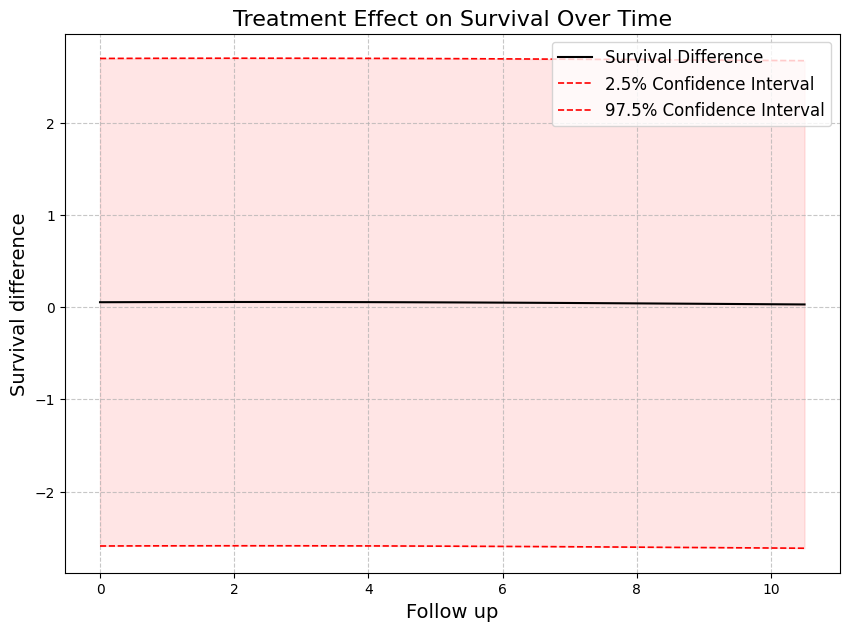


Interpretation of Treatment Effects:
--------------------------------------------------
Short-term effect (1 time unit): 0.0544
Mid-term effect (5 time units): 0.0512
Long-term effect (10 time units): 0.0308

The 95% confidence interval includes zero at some follow-up times,
suggesting that the treatment effect may not be statistically significant
throughout the entire follow-up period.

The positive survival difference indicates that treatment decreases
the risk of the outcome event compared to control.

By the end of the follow-up period (10 time units),
the absolute risk difference between treatment and control is 0.0308.
This represents approximately a 6.2% reduction in risk for the treated group.


In [16]:
# Visualize treatment effects
trial_itt.visualize_treatment_effects(max_followup=10)

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020;">
    <p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Key Insights from the Analysis
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>1. Treatment Efficacy: Strong Evidence with Some Uncertainty</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The treatment shows a significant reduction in risk, with a strong negative coefficient for <strong>assigned_treatment</strong> (-1.81, p < 0.0001), indicating a substantial beneficial effect. However, the treatment effect diminishes over time:
    <ul style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
        <br>
        <li><strong>Short-term effect:</strong> 5.44% risk reduction.</li>
        <li><strong>Mid-term effect:</strong> 5.12% risk reduction.</li>
        <li><strong>Long-term effect:</strong> 3.08% risk reduction.</li>
        <br>
    </ul>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;"> 
    While the treatment is effective, its impact fades over time, suggesting that while initial improvements are evident, sustained efficacy may be limited. The wide confidence intervals suggest that the estimates are not entirely precise, so additional investigation is needed to confirm these effects.
    </p>
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>2. Censoring Mechanisms and Group Differences</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    Censoring patterns differ across the groups, with a strong association between the variable <strong>x2</strong> and censoring in the pooled analysis. This effect is particularly pronounced in <strong>Group 0</strong> but disappears in <strong>Group 1</strong>. This finding suggests different censoring mechanisms in the two groups, which could be due to factors such as adherence, follow-up rates, or clinical protocols. Further examination of the underlying causes for these differences is crucial for understanding the data.
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>3. Treatment Assignment Patterns and Age Influence</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The analysis reveals that <strong>age</strong> is a significant predictor of treatment assignment, with older patients less likely to receive the treatment. This could reflect clinical trial protocols, which may preferentially assign treatments to younger populations, or it could signal potential selection bias. Additionally, variable <strong>x1</strong> is strongly associated with treatment assignment, suggesting that other covariates may play an important role in influencing treatment allocation.
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>4. Time-Related Effects: A Non-Linear Relationship</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The follow-up time has a complex relationship with the treatment effect, as indicated by the polynomial terms in the model:
    <ul style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
        <br>
        <li><strong>Linear terms:</strong> Both follow-up time and trial period show positive coefficients, suggesting an initial increase in risk.</li>
        <li><strong>Quadratic terms:</strong> Marginally significant negative coefficients imply that risk may stabilize or decrease after an initial rise.</li>
        <br>
    </ul>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    These findings suggest that while the treatment may have a growing impact early on, its effect might plateau as time progresses, and further investigation into the long-term dynamics is needed.
    <p>
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>5. Clinical Implications and Next Steps</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    While the statistical analysis shows a significant treatment effect, the diminishing impact over time raises questions about the sustainability of the treatment's benefits. Key areas for further exploration include:
    <ul style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
        <br>
        <li><strong>Identifying the clinical meaning of the observed risk reduction:</strong> Is a 3.08% reduction in risk clinically significant for this particular condition?</li>
        <li><strong>Investigating treatment adherence:</strong> Could decreasing adherence or treatment resistance explain the diminishing treatment effect?</li>
        <li><strong>Further analysis of censoring differences:</strong> What factors contribute to the disparities between <strong>Group 0</strong> and <strong>Group 1</strong>?</li>
        <br>
    </ul>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    Addressing these questions will provide deeper insights into the clinical relevance of the treatment, helping guide future clinical decision-making and research.
    </p>
    </p>
</div>

